In [148]:
import pandas as pd

In [181]:
books = pd.read_csv('Preprocessed_data.csv', index_col=False).reset_index(drop=True)

# Let's drop columns we will not need 
df = books[['user_id', 'rating', 'book_title', 'book_author', 'year_of_publication', 'Summary']]
df

In [150]:
# Let's check if we do not have any data missing
print('Null values: {}'.format(sum(df.isnull().any())))
# Or if there are not duplicates
print('duplicates: {}'.format(sum(df.duplicated())))

Null values: 0
duplicates: 0


In [151]:
# I am going to drop the 0 ratings as I am pretty sure they are supposed to be non ratings
df = df[df['rating'] != 0]

In [152]:
print('Data Summary:')
print('Number of ratings: {}'.format(len(df)))
print('Number of users: {}'.format(len(df['user_id'].unique())))
print('Number of books: {}'.format(len(df['book_title'].unique())))
print('Mean rating: {}'.format(round(df['rating'].mean(),2)))
print('Average number of ratings given by user: {}'.format(pd.DataFrame(df.groupby('user_id')['rating'].count()).mean()[0]))

Data Summary:
Number of ratings: 383852
Number of users: 68092
Number of books: 135573
Mean rating: 7.63
Average number of ratings given by user: 5.6372554778828645


In [178]:
df['rating'].describe()

count    383852.000000
mean          7.626710
std           1.841331
min           1.000000
25%           7.000000
50%           8.000000
75%           9.000000
max          10.000000
Name: rating, dtype: float64

# Data Cleaning

In [161]:
# Let's get the books that have more than 10 ratings
ratings = pd.DataFrame(df.groupby('book_title')['rating'].mean()).sort_values(ascending=False, by='rating')
over_10 = ratings[ratings['num of ratings'] > 10]
over_10

,rating,num of ratings
book_title,,
Postmarked Yesteryear: 30 Rare Holiday Postcards,10.000000,11
Dilbert: A Book of Postcards,9.923077,13
Harry Potter and the Chamber of Secrets Postcard Book,9.869565,23
Route 66 Postcards: Greetings from the Mother Road,9.727273,11
"The Return of the King (The Lord of The Rings, Part 3)",9.625000,16
...,...,...
Killing Time: A Novel of the Future,5.066667,15
Coal: A Human History,4.947368,19
The Sexual Life of Catherine M.,4.913043,23


In [162]:
# Aplly it to the main df
def get_num_of_ratings(bookname):
    if bookname in over_10.index:
        num_of_ratings = over_10[over_10.index == bookname]['num of ratings']
        return num_of_ratings[0]
    
df['num of ratings'] = df['book_title'].apply(get_num_of_ratings)

C:\Users\User\AppData\Local\Temp/ipykernel_21864/2745085126.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num of ratings'] = df['book_title'].apply(get_num_of_ratings)


In [163]:
# Drop the ratings for the books that have less than 10 ratings
# The dataset is pretty have so it would be an advantage for model building
dff = df.dropna()
dff.head(2)

,location,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_m,Summary,Category,num of ratings
31,"n/a, n/a, n/a",11676,34.7439,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,A Chinese immigrant who is convinced she is dy...,['Fiction'],116.0
32,"knoxville, tennessee, usa",29526,26.0000,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,A Chinese immigrant who is convinced she is dy...,['Fiction'],116.0


In [164]:
dff['book_title'].nunique()

5044

In [165]:
len(over_10)

5044

In [167]:
# Lets reduce the dataset to the most users that are the most active --> top 2000 with most number of ratings given
users = pd.DataFrame(dff.groupby('user_id')['rating'].mean()).sort_values(ascending=False, by='rating')
users['num of ratings'] = pd.DataFrame(dff.groupby('user_id')['rating'].count())
users.sort_values('num of ratings', ascending=False)[:2000]

top_2000 = users.sort_values('num of ratings', ascending=False)[:2000]
top_2000

,rating,num of ratings
user_id,,
11676,7.615701,2191
98391,8.799127,458
153662,9.064690,371
16795,7.682320,362
95359,7.931818,308
...,...,...
147420,8.307692,13
201697,8.307692,13
137137,9.307692,13


In [168]:
def get_num_of_ratings_user(user_id):

    if user_id in top_2000.index:
        num_of_ratings_user = top_2000[top_2000.index == user_id]['num of ratings']
        return num_of_ratings_user.values[0]
    
dff['num of ratings user'] = dff['user_id'].apply(get_num_of_ratings_user)

C:\Users\User\AppData\Local\Temp/ipykernel_21864/113909040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['num of ratings user'] = dff['user_id'].apply(get_num_of_ratings_user)


In [169]:
# rest users
dff = dff.dropna()

In [170]:
# It turns out that some books have more than one publication
# Some of the publications have different summary, which turns out to be a problem in model building
# I will map the summary of each movie so it is the same for each publication
over_2publications = pd.DataFrame(dff.groupby(['book_title'])['Summary'].nunique())
over_2publications = over_2publications[over_2publications['Summary'] != 1]

def change_summ(title):
    id_of_longest_summary = dff[dff['book_title'] == title]['Summary'].apply(lambda x: len(x)).idxmax()
    return dff.loc[id_of_longest_summary]['Summary']
    

dff['Summary'] = dff['book_title'].apply(change_summ)

In [171]:
# Lets make sure it works
pd.DataFrame(dff.groupby(['book_title'])['Summary'].nunique()).sort_values('Summary')

,Summary
book_title,
'Salem's Lot,1
Summer Moon,1
Summer Light,1
Summer Island,1
Sullivan's Woman (Silhouette Single Title),1
...,...
High Five (A Stephanie Plum Novel),1
High Fidelity. (Dt. Ausgabe),1
High Fidelity,1


<AxesSubplot:>

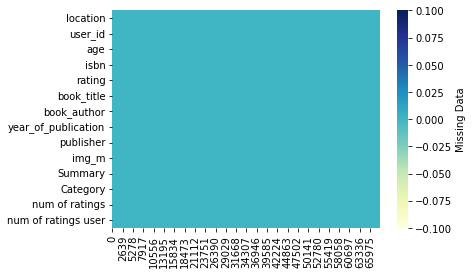

In [177]:
sns.heatmap(dff.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

In [173]:
print('Data Summary:')
print('Number of ratings: {}'.format(len(dff)))
print('Number of users: {}'.format(len(dff['user_id'].unique())))
print('Number of books: {}'.format(len(dff['book_title'].unique())))
print('Mean rating: {}'.format(round(dff['rating'].mean(),2)))
print('Mean number of ratings per book: {}'.format(round(dff['num of ratings'].mean(),2)))
print('Average number of ratings given by user: {}'.format(pd.DataFrame(dff.groupby('user_id')['rating'].count()).mean()[0]))

Data Summary:
Number of ratings: 68588
Number of users: 2000
Number of books: 5007
Mean rating: 7.9
Mean number of ratings per book: 69.78
Average number of ratings given by user: 34.294


In [174]:
dff.to_csv('ratings_with_features.csv', index=False)

In [175]:
dff = pd.read_csv('ratings_with_features.csv')

In [176]:
dff

,location,user_id,age,isbn,rating,book_title,book_author,year_of_publication,publisher,img_m,Summary,Category,num of ratings,num of ratings user
0,"n/a, n/a, n/a",11676,34.7439,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,A Chinese immigrant who is convinced she is dy...,['Fiction'],116.0,2191.0
1,"knoxville, tennessee, usa",29526,26.0000,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,A Chinese immigrant who is convinced she is dy...,['Fiction'],116.0,62.0
2,"san antonio, texas, usa",46398,37.0000,0399135782,9,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,A Chinese immigrant who is convinced she is dy...,['Fiction'],116.0,132.0
3,"homer, alaska, usa",148712,34.7439,0399135782,10,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,A Chinese immigrant who is convinced she is dy...,['Fiction'],116.0,19.0
4,"colorado springs, colorado, usa",230522,52.0000,0399135782,7,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,A Chinese immigrant who is convinced she is dy...,['Fiction'],116.0,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68583,"toronto, ontario, canada",270713,27.0000,0312095376,9,The Bride,Bapsi Sidhwa,1983.0,St Martins Pr,http://images.amazon.com/images/P/0312095376.0...,9,9,18.0,85.0
68584,"west bend, wisconsin, usa",270820,52.0000,0606298347,7,The Vision,Dean R. Koontz,1986.0,Turtleback Books Distributed by Demco Media,http://images.amazon.com/images/P/0606298347.0...,Mary Bergen&#39;s remarkable clairvoyant talen...,9,23.0,49.0
68585,"gahanna/columbus, ohio, usa",274061,26.0000,1551663147,10,Fever,Elizabeth Lowell,1997.0,Mira,http://images.amazon.com/images/P/1551663147.0...,This unforgettable sequel to Like Boogie on Tu...,['Utah'],25.0,103.0
68586,"pittsburgh, pennsylvania, usa",275970,46.0000,1586210661,9,Me Talk Pretty One Day,David Sedaris,2001.0,Time Warner Audio Major,http://images.amazon.com/images/P/1586210661.0...,9,9,218.0,47.0


In [179]:
dff.columns


Index(['location', 'user_id', 'age', 'isbn', 'rating', 'book_title',
       'book_author', 'year_of_publication', 'publisher', 'img_m', 'Summary',
       'Category', 'num of ratings', 'num of ratings user'],
      dtype='object')